<a href="https://colab.research.google.com/github/dkayikci/ML-Arch/blob/main/Resnet18(lr0_002_and_30epochs_92_83seed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List the contents of your Google Drive root directory
print("Contents of MyDrive:")
!ls /content/drive/MyDrive/

# List the contents of the MetaHittite directory (if it exists)
print("\nContents of MetaHittite:")
!ls /content/drive/MyDrive/MetaHittite/

# List the contents of the stelea1500x1000pxsL2 directory (if it exists)
print("\nContents of stelea1500x1000pxsL2:")
!ls /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/

print("\nContents of stelea1500x1000pxsL2:")
!ls /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/

print("\nContents of stelea1500x1000pxsL2:")
!ls /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/supportL2_112

Contents of MyDrive:
 MetaHittite   UAB   UNESCO  'yl tez ve makalesi'

Contents of MetaHittite:
 HittiteCNNMAML        Hittites_Only_RESNET_18	 MAMLFSLHittite    stelea1500x1000pxsL2
 Hittite_Human_Tests   kodmodeldenemeler	'orjinal kodlar'   Untitled0.ipynb

Contents of stelea1500x1000pxsL2:
FSL  OSL  RESERVES_ALACA  RESERVES_ASLAN  RESERVES_KARKA

Contents of stelea1500x1000pxsL2:
queryL2_24  supportL2_112

Contents of stelea1500x1000pxsL2:
alaca  aslan  karka  sakca


In [ ]:
import os
os.chdir('/content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL')

In [ ]:
!pip install torch torchvision
!pip install higher
!pip install evograd
!pip install easyfsl
!pip install scikit-learn


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import glob
import numpy as np
import higher
import random
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.optim import Adam
from torchvision.models import resnet18
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# Veri kümesi ve dönüşümler
class HittiteSteleDatasetL2(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(self.root))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = glob.glob(self.root + "/*/*.jpg")

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[img_path.split("/")[-2]]
        return img, label

    def __len__(self):
        return len(self.image_paths)

class ResNet18Modified(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# Dataset Transformations
root = "/content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL"
transform = Compose([Resize((224, 224)), ToTensor(), Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

support_dataset = ImageFolder(os.path.join(root, "supportL2_112"), transform=transform)
query_dataset = ImageFolder(os.path.join(root, "queryL2_24"), transform=transform)

support_dataloader = DataLoader(support_dataset, batch_size=28, shuffle=True)
query_dataloader = DataLoader(query_dataset, batch_size=6, shuffle=True)

In [ ]:
# Training
resnet18_modified = ResNet18Modified(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_modified.parameters(), lr=0.002)

num_epochs = 30
for epoch in range(num_epochs):
    for images, labels in support_dataloader:
        optimizer.zero_grad()
        outputs = resnet18_modified(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.5544
Epoch [1/10], Loss: 0.8815
Epoch [1/10], Loss: 2.9487
Epoch [1/10], Loss: 1.9652
Epoch [2/10], Loss: 0.6040
Epoch [2/10], Loss: 0.5240
Epoch [2/10], Loss: 0.8776
Epoch [2/10], Loss: 0.9194
Epoch [3/10], Loss: 0.5470
Epoch [3/10], Loss: 0.6826
Epoch [3/10], Loss: 0.7339
Epoch [3/10], Loss: 0.5419
Epoch [4/10], Loss: 0.4742
Epoch [4/10], Loss: 0.4129
Epoch [4/10], Loss: 0.4853
Epoch [4/10], Loss: 0.1955
Epoch [5/10], Loss: 0.2456
Epoch [5/10], Loss: 0.4588
Epoch [5/10], Loss: 0.2988
Epoch [5/10], Loss: 0.2483
Epoch [6/10], Loss: 0.1587
Epoch [6/10], Loss: 0.2390
Epoch [6/10], Loss: 0.2414
Epoch [6/10], Loss: 0.6768
Epoch [7/10], Loss: 0.2102
Epoch [7/10], Loss: 0.0682
Epoch [7/10], Loss: 0.5197
Epoch [7/10], Loss: 0.6399
Epoch [8/10], Loss: 0.3075
Epoch [8/10], Loss: 0.1267
Epoch [8/10], Loss: 0.1893
Epoch [8/10], Loss: 0.2873
Epoch [9/10], Loss: 0.1616
Epoch [9/10], Loss: 0.2449
Epoch [9/10], Loss: 0.3855
Epoch [9/10], Loss: 0.4833
Epoch [10/10], Loss: 0.2467


In [ ]:
# Test and calculations
def evaluate_model(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds


In [ ]:
# Evaluation with support(training) dataset
support_labels, support_preds = evaluate_model(resnet18_modified, support_dataloader)
# Evaluation with query(test) dataset
query_labels, query_preds = evaluate_model(resnet18_modified, query_dataloader)

In [ ]:
# Confusion matrix
print("Support Data Confusion Matrix")
print(confusion_matrix(support_labels, support_preds))
print("Support Data Classification Report")
print(classification_report(support_labels, support_preds))

print("Query Data Confusion Matrix")
print(confusion_matrix(query_labels, query_preds))
print("Query Data Classification Report")
print(classification_report(query_labels, query_preds))

Support Data Confusion Matrix
[[28  0  0  0]
 [ 1 27  0  0]
 [ 2  0 26  0]
 [ 0  2  4 22]]
Support Data Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       0.93      0.96      0.95        28
           2       0.87      0.93      0.90        28
           3       1.00      0.79      0.88        28

    accuracy                           0.92       112
   macro avg       0.93      0.92      0.92       112
weighted avg       0.93      0.92      0.92       112

Query Data Confusion Matrix
[[6 0 0 0]
 [1 4 1 0]
 [0 1 5 0]
 [0 1 0 5]]
Query Data Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.67      0.67      0.67         6
           2       0.83      0.83      0.83         6
           3       1.00      0.83      0.91         6

    accuracy                           0.83        24
   macr

In [ ]:
!pip install pandas seaborn matplotlib
!pip install seaborn

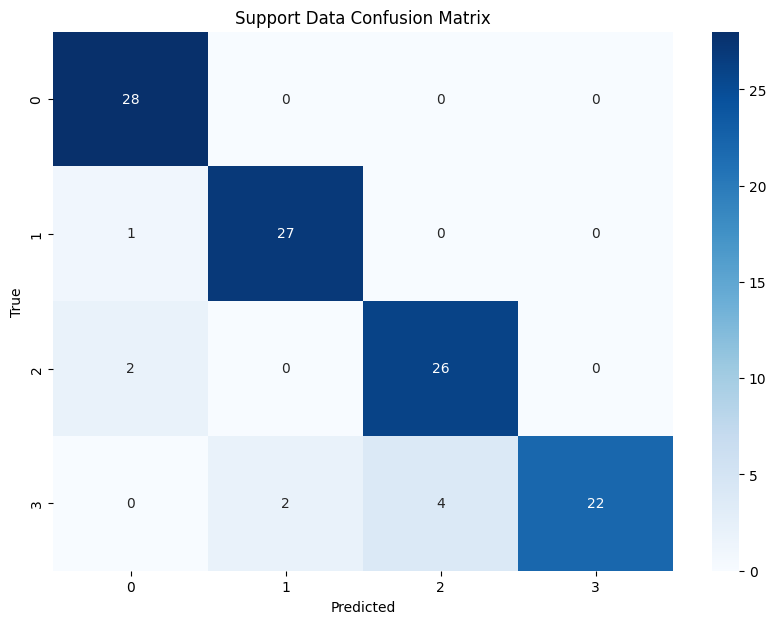

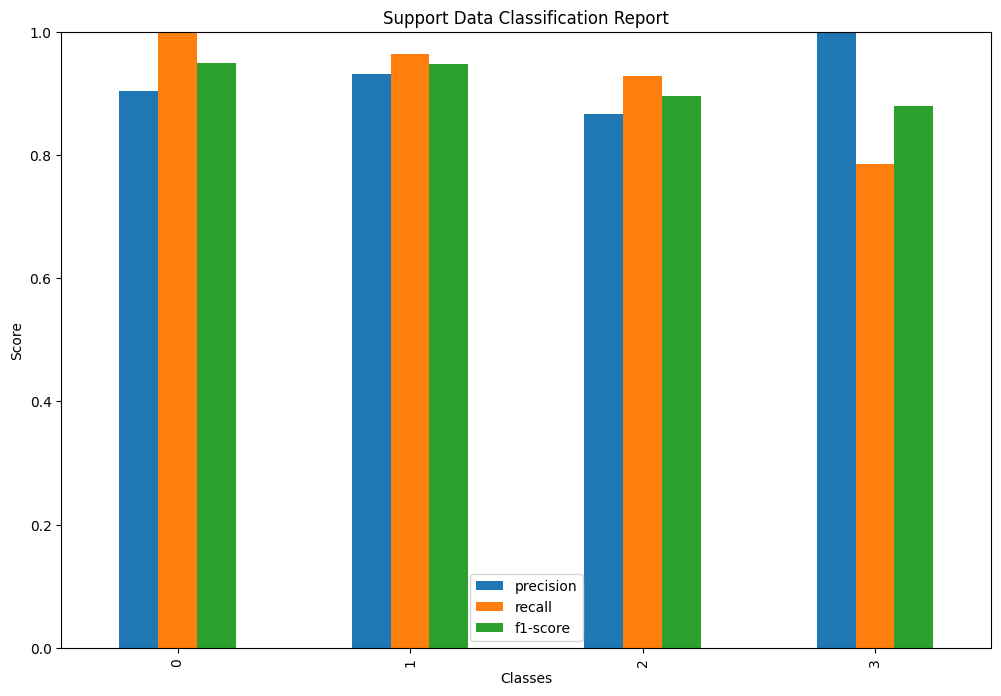

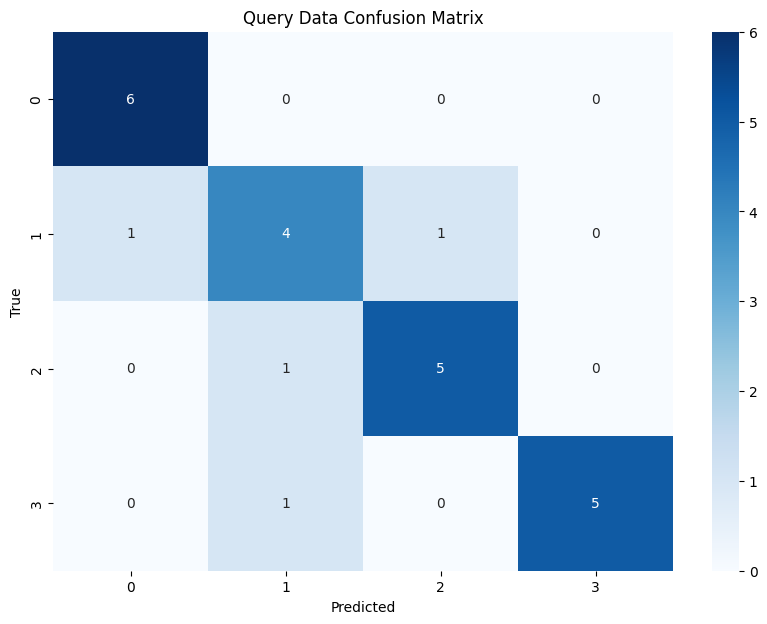

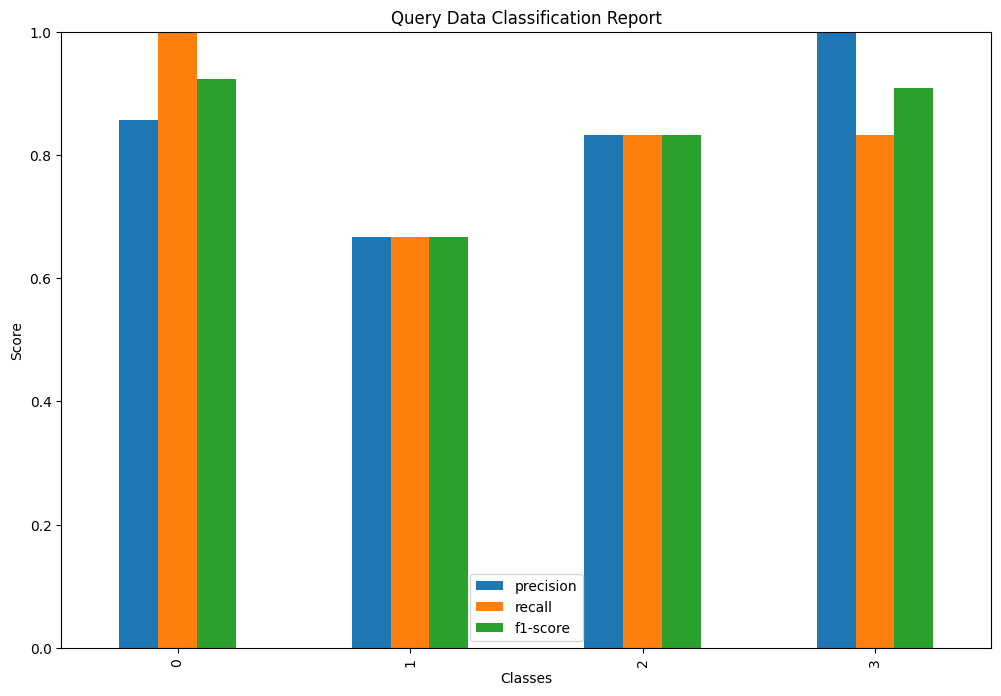

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix design
support_cm = confusion_matrix(support_labels, support_preds)
query_cm = confusion_matrix(query_labels, query_preds)

# Accuracy Report
support_class_report = classification_report(support_labels, support_preds, output_dict=True)
query_class_report = classification_report(query_labels, query_preds, output_dict=True)

# Visualization of Confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Visualization of Accuracy Report
def plot_classification_report(class_report, title):
    metrics = ['precision', 'recall', 'f1-score']
    class_names = list(class_report.keys())[:-3]  # accuracy, macro avg ve weighted avg hariç sınıf isimleri
    data = {metric: [class_report[class_name][metric] for class_name in class_names] for metric in metrics}
    df = pd.DataFrame(data, index=class_names)

    df.plot(kind='bar', figsize=(12, 8))
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Classes')
    plt.ylim(0, 1)
    plt.show()

# Visualization of confusion matrix and accuracy report for support(training) dataset
plot_confusion_matrix(support_cm, "Support Data Confusion Matrix")
plot_classification_report(support_class_report, "Support Data Classification Report")

# Visualization of confusion matrix and accuracy report for query(test) dataset
plot_confusion_matrix(query_cm, "Query Data Confusion Matrix")
plot_classification_report(query_class_report, "Query Data Classification Report")
